## The aim is to register each tissue images in the stained and unstained WSIs. To do this, we first need to crop and save each individual tissue in each WSI and save them as a png file. Then we can pad the two images together and register them by editing the registration code from image_registration.ipynb.
## The path of the images are in: \\shelter\Kyu\unstain2stain\biomax_images

In [2]:
#importing openslide:
OPENSLIDE_PATH = r'C:\Users\Kevin\Desktop\openslide-win64-20221217\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [3]:
import numpy as np
import time
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import cv2
import os
from matplotlib import pyplot as plt
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.color import rgb2gray
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
import os
import cv2
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import skimage.measure
import scipy.stats as stats
from glob import glob
from time import time
from skimage.measure import label, regionprops_table


In [3]:
def _time(f):
    """
    Helper function: Measures time taken for a certain function that we suspect that takes long. Simply run _time(function_name)
    """
    def wrapper(*args,**kwargs):
        start=time()
        r=f(*args,**kwargs)
        end=time()
        print("%s timed %f" %(f.__name__,end-start))
        return r
    return wrapper

In [4]:
def xml_to_df(xml_filepath):
    """
    Helper function from xml2trainingdata.ipynb
    input: annotation xml file
    output: dataframe of X,Y coordinates of the contours
    Can be used for multiclass and just simple ROI as well.
    """
    tree = ET.parse(xml_filepath)
    root = tree.getroot()
    append_df = []
    for index, Annotation in enumerate(root.iter("Annotation")):
        for Region in Annotation.iter('Region'):
            x = np.array([Vertex.get('X') for Vertex in Region.iter('Vertex')])
            y = np.array([Vertex.get('Y') for Vertex in Region.iter('Vertex')])
            id = np.array([int(Region.get('Id'))])
            classnames = index + 1
            coord_dict = {"ClassNames": [classnames], "X": [x], "Y": [y], "ID": [id]}
            df = pd.DataFrame(data = coord_dict)
            df.ID = df.ID.astype(int)
            append_df.append(df)
    coord_df = pd.concat(append_df).reset_index(drop=True)
    return(coord_df)

In [5]:
def df_to_image_mask(xml_filepath, ndpi_filepath,downsample_factor, general_save_path):
    """
    Helper function from xml2trainingdata.ipynb
    input: xml file path and ndpi file path of the wsi image, and the desired downsample factor
    output: binary mask of the wsi image
    """
    coord_df = xml_to_df(xml_filepath)
    slide = openslide.open_slide(ndpi_filepath)
    rgb_dim = slide.dimensions
    print("Dimension of level 0 of the image is: ",rgb_dim)
    slide_level_dim = slide.level_dimensions
    num_levels = len(slide_level_dim)
    print("Number of levels in this image are:",num_levels)
    factors = slide.level_downsamples
    print("Each level is downsampled by:",factors)
    target_level = slide.get_best_level_for_downsample(downsample_factor)
    target_dim = slide.level_dimensions[target_level]
    rsf = [x/y for x,y in zip(rgb_dim,target_dim)]
    blank = np.zeros((target_dim[1],target_dim[0]), dtype = np.uint8) #white
    for idx, row in coord_df.iterrows():
        xx = row.X.astype('int')
        yy = row.Y.astype('int')
        xx = [round(x/rsf[0]) for x in xx]
        yy = [round(x/rsf[0]) for x in yy]
        xy = list(zip(xx,yy))
        contours = np.array(xy)
        mask = cv2.fillPoly(blank, pts=[contours.astype(int)], color=255)
    # image_resized = slide.read_region(location=(0,0),level=target_level,size=target_dim)
    # mask_resized = cv2.resize(mask,[_//round(rsf[0]) for _ in mask.shape],interpolation=cv2.INTER_NEAREST)
    # mask = np.rot90(mask, k = 1, axes= (1,0))
    tmp = os.path.basename(ndpi_filepath)
    ndpi_name = os.path.splitext(tmp)[0]
    save_path = os.path.join(general_save_path,ndpi_name + ".png")
    cv2.imwrite(save_path,mask) #save binary mask
    return ("Image saved successfully!")

### for stained: downsample by 8x to find the bounding box for each tissue image in WSI, and then get those bounding box coordinates multiplied by 8x again, and use those coordinates to read region with no downsample, but only that region of interest and then crop. (modify read_region function to read at full resolution, but only the bounding box by changing location and size). But use binary mask of the unstained to find the order, so we can save the images from top left to bottom right.

### for unstained: use xml coordinates and just find the bounding box from there and then read region with no downsample and crop. But use binary mask of the unstained to find the order, so we can save the images from top left to bottom right.

### To find order: get both binary images/masks of the raw ndpi, and because their relative positions are so different, we crop both images so that only the tissues are shown, meaning that there is no "white space" in the image. And then if we normalize the centroids with respect to the size of the cropped image, the centroids should be the same

In [7]:
# use df_to_image_mask to create binarymask of unstained with downsample 16x:
df_to_image_mask(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk244a.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk244a.ndpi',16,r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks')
df_to_image_mask(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk481.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk481.ndpi',16,r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks')
df_to_image_mask(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\skn1001.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\skn1001.ndpi',16,r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks')

Dimension of level 0 of the image is:  (199680, 98560)
Number of levels in this image are: 8
Each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
Dimension of level 0 of the image is:  (184320, 98560)
Number of levels in this image are: 8
Each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
Dimension of level 0 of the image is:  (192000, 98560)
Number of levels in this image are: 8
Each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)


'Image saved successfully!'

In [6]:
# for stained:
def stained_crop(stain_ndpi_filepath, general_save_path, binary_mask_path, save = True):
    slide = openslide.open_slide(stain_ndpi_filepath)
    tmp = os.path.basename(stain_ndpi_filepath)
    ndpi_name = os.path.splitext(tmp)[0]

# since image_resized is read with downsample, now find the coordinates of the bounding box for each image
# to do that, first create a binary mask (which is already found in binary_image_path and then use label to find bbox of each label (image).

    binary_img = Image.open(binary_mask_path)
    labeledbw = label(np.array(binary_img))
    props = regionprops_table(labeledbw, properties = ('bbox','label'))
    # find bbox to crop
    b0 = props.get('bbox-0') #xmin
    b1 = props.get('bbox-1') #ymin
    b2 = props.get('bbox-2') #xmax
    b3 = props.get('bbox-3') #ymax

    # the four lines are only for skn1001, comment out for others (skn1001 for some reason has a mystery label that screws up the min values for crop)

    b0 = b0[:-1]
    b1 = b1[:-1]
    b2 = b2[:-1]
    b3 = b3[:-1]

    xmin = np.min(b0)
    ymin = np.min(b1)
    xmax = np.max(b2)
    ymax = np.max(b3)
    newlabeledbw = labeledbw[xmin:xmax,ymin:ymax] #crop image so no white space
    size = newlabeledbw.shape
    plt.imshow(newlabeledbw.astype(np.int32))
    newprops = regionprops_table(newlabeledbw, properties = ('centroid','label'))
    c0 = newprops.get('centroid-0')
    c1 = newprops.get('centroid-1')
    c0 = [round(x / size[0],4) for x in c0]
    c1 = [round(x / size[1],4) for x in c1]
    stained_centroid_tuple = list(zip(c0,c1)) #return centroid_tuple so that this can be used for unstain
    id_list = np.arange(1,np.max(labeledbw))
    stained_centroid_tuple_list = list(zip(stained_centroid_tuple,id_list))
    if save:
        for id in range(1,np.max(labeledbw)+1):
            bwtarget = labeledbw == id
            ind = np.argwhere(bwtarget)
            xx_min = np.min(ind[:,1])
            xx_max = np.max(ind[:,1])
            yy_min = np.min(ind[:,0])
            yy_max = np.max(ind[:,0])
            x_min = round(xx_min*16) #downsample factor used to create binary_masks in both stained and unstained was 16.
            x_max = round(xx_max*16)
            y_min = round(yy_min*16)
            y_max = round(yy_max*16)
            location = (x_min,y_min)
            dim = (x_max-x_min,y_max-y_min)
            fin_image = slide.read_region(location= location,level=0,size=dim)
            fin_image = np.array(fin_image)
            save_path = os.path.join(general_save_path,ndpi_name)
            save_path = os.path.join(save_path, ndpi_name + str(id - 1) + ".png")
            Image.fromarray(fin_image).save(save_path)
        print("Image saved successfully!")
    else:
        return stained_centroid_tuple_list

456
487
3184
5178


[((0.0995, 0.2366), 1),
 ((0.1129, 0.0862), 2),
 ((0.1169, 0.6783), 3),
 ((0.1243, 0.3729), 4),
 ((0.1813, 0.819), 5),
 ((0.1585, 0.5197), 6),
 ((0.3418, 0.2347), 7),
 ((0.3615, 0.0724), 8),
 ((0.3924, 0.5027), 9),
 ((0.3807, 0.6616), 10),
 ((0.3847, 0.4016), 11),
 ((0.3897, 0.8111), 12),
 ((0.6023, 0.0632), 13),
 ((0.6257, 0.3696), 14),
 ((0.6075, 0.2152), 15),
 ((0.6331, 0.5064), 16),
 ((0.6444, 0.8086), 17),
 ((0.6552, 0.6535), 18),
 ((0.8678, 0.0691), 19),
 ((0.8721, 0.218), 20),
 ((0.8982, 0.506), 21),
 ((0.9015, 0.6547), 22),
 ((0.9018, 0.9451), 23),
 ((0.8785, 0.3621), 24)]

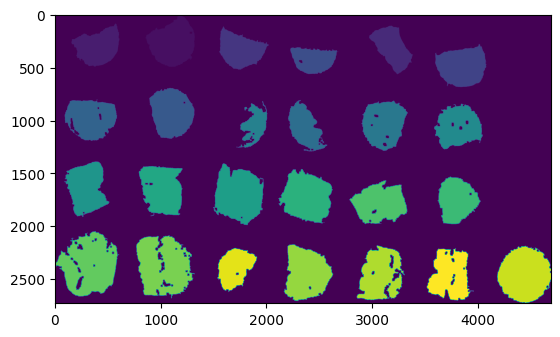

In [22]:
stained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\sk244ahe.ndpi', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\sk244a.png', save = False)

[((0.0541, 0.0837), 1),
 ((0.0567, 0.2017), 2),
 ((0.0516, 0.4415), 3),
 ((0.0681, 0.5768), 4),
 ((0.0663, 0.6986), 5),
 ((0.0669, 0.8231), 6),
 ((0.087, 0.9656), 7),
 ((0.0747, 0.3302), 8),
 ((0.1933, 0.0743), 9),
 ((0.1985, 0.1998), 10),
 ((0.1972, 0.4521), 11),
 ((0.1986, 0.3214), 12),
 ((0.1998, 0.5728), 13),
 ((0.203, 0.8265), 14),
 ((0.2117, 0.694), 15),
 ((0.2155, 0.9624), 16),
 ((0.3396, 0.1899), 17),
 ((0.3459, 0.0653), 18),
 ((0.3578, 0.4336), 19),
 ((0.3475, 0.8155), 20),
 ((0.3511, 0.3163), 21),
 ((0.3311, 0.5518), 22),
 ((0.3522, 0.6912), 23),
 ((0.3666, 0.9521), 24),
 ((0.3727, 0.5774), 25),
 ((0.4898, 0.0572), 26),
 ((0.4936, 0.1866), 27),
 ((0.4999, 0.5488), 28),
 ((0.497, 0.4262), 29),
 ((0.5045, 0.6761), 30),
 ((0.4952, 0.3019), 31),
 ((0.5073, 0.826), 32),
 ((0.5213, 0.9539), 33),
 ((0.6374, 0.0454), 34),
 ((0.6376, 0.1813), 35),
 ((0.644, 0.3026), 36),
 ((0.6516, 0.7985), 37),
 ((0.6478, 0.5471), 38),
 ((0.6519, 0.4168), 39),
 ((0.6508, 0.6712), 40),
 ((0.6597, 0.93

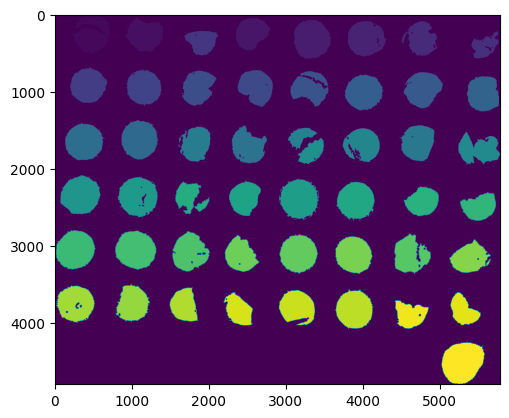

In [15]:
stained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\sk481he.ndpi', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\sk481.png', save = False)

[((0.0459, 0.149), 1),
 ((0.0502, 0.0547), 2),
 ((0.0398, 0.2321), 3),
 ((0.0551, 0.3916), 4),
 ((0.0644, 0.4765), 5),
 ((0.0591, 0.5526), 6),
 ((0.0634, 0.6355), 7),
 ((0.0666, 0.3126), 8),
 ((0.079, 0.7207), 9),
 ((0.0955, 0.967), 10),
 ((0.0852, 0.8047), 11),
 ((0.097, 0.8896), 12),
 ((0.161, 0.2243), 13),
 ((0.1699, 0.4757), 14),
 ((0.1668, 0.3131), 15),
 ((0.1628, 0.1406), 16),
 ((0.1742, 0.3855), 17),
 ((0.1761, 0.719), 18),
 ((0.1889, 0.799), 19),
 ((0.189, 0.555), 20),
 ((0.1745, 0.0619), 21),
 ((0.1938, 0.6296), 22),
 ((0.2013, 0.8685), 23),
 ((0.2133, 0.9653), 24),
 ((0.2765, 0.2216), 25),
 ((0.284, 0.3898), 26),
 ((0.2852, 0.4682), 27),
 ((0.2954, 0.5571), 28),
 ((0.2853, 0.3081), 29),
 ((0.2844, 0.1353), 30),
 ((0.2915, 0.6352), 31),
 ((0.3062, 0.8058), 32),
 ((0.2929, 0.0621), 33),
 ((0.2934, 0.7208), 34),
 ((0.287, 0.8853), 35),
 ((0.2954, 0.9622), 36),
 ((0.3861, 0.1385), 37),
 ((0.3745, 0.0548), 38),
 ((0.3892, 0.2972), 39),
 ((0.38, 0.3763), 40),
 ((0.389, 0.5485), 41)

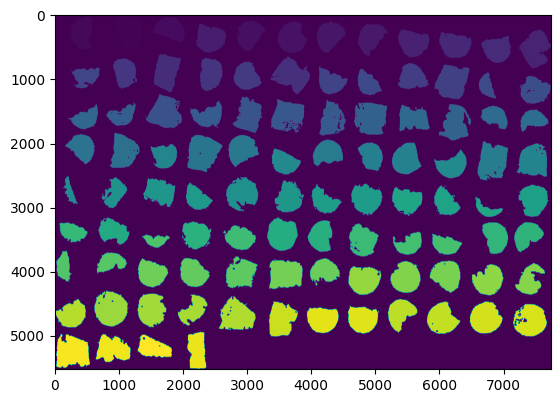

In [7]:
stained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\skn1001he.ndpi', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images', r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\skn1001.png', save = False)

In [8]:
#compare the two centroids:
def find_id (list1, list2):
    if len(list1) != len(list2):
        print("Two lists must have the same length, please fix!")
        return
    else:
        difference_ra = []
        order_ra = []
        for idx in range(0,len(list1)):
            for idx1 in range(0,len(list1)):
                difference_tup = np.subtract(list1[idx][0],list2[idx1][0]) #list1 is reference.
                abs_difference = abs(difference_tup[0]) + abs(difference_tup[1])
                difference_ra.append(abs_difference)
            matched_id = np.argmin(difference_ra)
            difference_ra = []
            order_ra.append(matched_id)
    return list(order_ra)

In [9]:
def unstained_crop(xml_filepath, unstain_ndpi_filepath, stain_ndpi_filepath, unstained_binary_mask_filepath, stained_binary_mask_filepath, general_save_path):
    """
    Function to crop the unstained ndpi to individual tissue png files. Important: Crop stained first and then run this, since this function ensures that the unstained images get cropped in the same order as the stained version and saved with the same name.
    input: xml file path, ndpi file path of the stained and unstained version. Also need binary mask of the same ndpi file path, which can simply be generated by downsampling the raw file. The downsampling is done previously in this notebook.
    output: the cropped images with same order as stained.
    """
    coord_df = xml_to_df(xml_filepath)
    slide = openslide.open_slide(unstain_ndpi_filepath)
    rgb_dim = slide.dimensions
    print("Dimension of level 0 of the unstained image is: ",rgb_dim)
    slide_level_dim = slide.level_dimensions
    num_levels = len(slide_level_dim)
    print("Number of levels in this unstained image are:",num_levels)
    factors = slide.level_downsamples
    print("For unstained image, each level is downsampled by:",factors)
    tmp = os.path.basename(xml_filepath)
    ndpi_name = os.path.splitext(tmp)[0]
    stained_centroid_tuple_list = stained_crop(stain_ndpi_filepath, general_save_path, stained_binary_mask_filepath, save = False) #get centroid tuples for stained
    unstained_binary_mask = Image.open(unstained_binary_mask_filepath)
    unstained_binary_mask = np.array(unstained_binary_mask)
    dim = unstained_binary_mask.shape
    binary_img = unstained_binary_mask > 0
    labeledbw = label(np.array(binary_img))
    props = regionprops_table(labeledbw, properties = ('bbox','label'))
    # find bbox to crop
    b0 = props.get('bbox-0') #xmin
    b1 = props.get('bbox-1') #ymin
    b2 = props.get('bbox-2') #xmax
    b3 = props.get('bbox-3') #ymax

    # the four lines are only for skn1001, comment out for others (skn1001 for some reason has a mystery label that screws up the min values for crop)
    b0 = b0[:-1]
    b1 = b1[:-1]
    b2 = b2[:-1]
    b3 = b3[:-1]

    xmin = np.min(b0)
    ymin = np.min(b1)
    xmax = np.max(b2)
    ymax = np.max(b3)
    cX_ra = []
    cY_ra = []
    for idx, row in coord_df.iterrows(): # now get centroid tuple for unstained first
        # to get centroid tuple:
        xx = row.X.astype('int')
        yy = row.Y.astype('int')
        x_ratio = ymin * 16
        xxx = [n - x_ratio for n in xx]
        y_ratio = xmin * 16
        yyy = [n - y_ratio for n in yy]
        xy = list(zip(xxx,yyy))
        xy = np.array(xy)
        moments = cv2.moments(xy)
        cX = int(moments["m10"] / moments["m00"])
        cY = int(moments["m01"] / moments["m00"])
        cX_ra.append(cX)
        cY_ra.append(cY)
    x_ratio1 = (dim[1]-(ymax-ymin)) * 16
    y_ratio1 = (dim[0]-(xmax-xmin)) * 16
    cX_ra1 = [round(p / (rgb_dim[0] - x_ratio1),4) for p in cX_ra]
    cY_ra1 = [round(p / (rgb_dim[1]- y_ratio1),4) for p in cY_ra]
    unstained_centroid_tuple = list(zip(cY_ra1,cX_ra1))
    id_list = np.arange(0,coord_df.shape[0])
    unstained_centroid_tuple_list = list(zip(unstained_centroid_tuple,id_list))
    order = find_id(stained_centroid_tuple_list,unstained_centroid_tuple_list)
    print("order that is getting saved is {}".format(order))

    # to crop with same order as stained:
    for idx, _ in coord_df.iterrows():
        xx = coord_df.X[order[idx]].astype('int')
        yy = coord_df.Y[order[idx]].astype('int')
        x_min = np.min(xx)
        x_max = np.max(xx)
        y_min = np.min(yy)
        y_max = np.max(yy)
        location = (x_min,y_min)
        dim = (x_max-x_min,y_max-y_min)
        image_resized = slide.read_region(location= location,level=0,size=dim)
        image_resized = np.array(image_resized)
        final_img = Image.fromarray(image_resized)
        save_path = os.path.join(general_save_path,ndpi_name)
        save_path = os.path.join(save_path, ndpi_name + str(idx) + ".png")
        final_img.save(save_path)
    print("Images saved successfully!")

Dimension of level 0 of the unstained image is:  (199680, 98560)
Number of levels in this unstained image are: 8
For unstained image, each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
order that is getting saved is [2, 0, 18, 24, 17, 22, 5, 3, 11, 20, 10, 19, 4, 9, 6, 12, 21, 14, 1, 7, 13, 15, 16, 8, 23]
Images saved successfully!


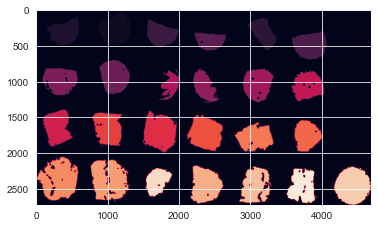

In [13]:
unstained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk244a.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk244a.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\sk244ahe.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks\sk244a.png',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\sk244a.png',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images')

Dimension of level 0 of the unstained image is:  (184320, 98560)
Number of levels in this unstained image are: 8
For unstained image, each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
order that is getting saved is [45, 46, 6, 25, 26, 37, 38, 47, 0, 5, 8, 7, 24, 36, 27, 39, 4, 1, 10, 35, 9, 23, 28, 40, 23, 2, 3, 22, 12, 29, 11, 34, 41, 13, 16, 17, 33, 48, 20, 30, 42, 15, 14, 18, 31, 21, 19, 43, 32]
Images saved successfully!


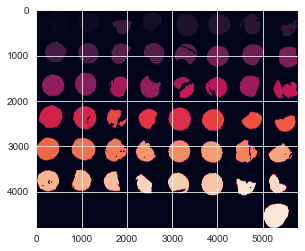

In [25]:
unstained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk481.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\sk481.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\sk481he.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks\sk481.png',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\sk481.png',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images')

Dimension of level 0 of the unstained image is:  (192000, 98560)
Number of levels in this unstained image are: 8
For unstained image, each level is downsampled by: (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)
order that is getting saved is [66, 65, 67, 73, 74, 8, 9, 69, 10, 75, 11, 87, 68, 37, 70, 64, 85, 57, 42, 49, 63, 50, 88, 76, 71, 30, 36, 48, 72, 62, 51, 95, 61, 99, 89, 77, 60, 59, 24, 29, 47, 79, 52, 98, 78, 84, 35, 94, 58, 28, 86, 18, 34, 23, 53, 46, 80, 93, 97, 83, 4, 33, 45, 22, 81, 82, 0, 54, 27, 96, 92, 17, 1, 5, 26, 21, 44, 16, 32, 43, 56, 90, 91, 55, 6, 15, 20, 25, 2, 40, 41, 31, 13, 12, 39, 38, 19, 7, 3, 14]
Images saved successfully!


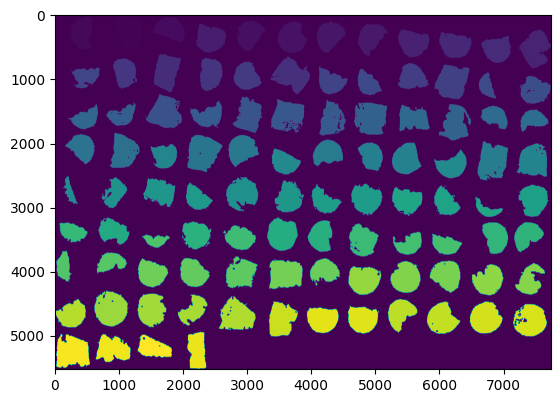

In [10]:
unstained_crop(r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\skn1001.xml', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\skn1001.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\skn1001he.ndpi',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\entire_binary_masks\skn1001.png',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\entire_binary_masks\skn1001.png',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images')

### Now that the stained and unstained images are cropped with the same name/order, let's pad these images together! Write a function to do this:

In [12]:
# function to pad images to same size:
def pad_two_images(img_list1_path, img_list2_path, save_path_img1, save_path_img2):
    """
    Pads two images from its respective list- the image pair must have the same order in the file path.
    input: image list 1 and list 2 file path.
    output: saves padded image so that the two images have same width and height (max width and height are used)
    """
    img_list1 = [_ for _ in os.listdir(img_list1_path) if _.endswith(".png")]
    img_list2 = [_ for _ in os.listdir(img_list2_path) if _.endswith(".png")]
    img_name1 = [x.replace('.png','') for x in img_list1]
    img_name2 = [x.replace('.png','') for x in img_list2]
    img_list1_complete = [os.path.join(img_list1_path, x) for x in img_list1]
    img_list2_complete = [os.path.join(img_list2_path, x) for x in img_list2]
    list_length = len(img_list1)
    if len(img_list1) != len(img_list2):
        print("Both image lists must have the same number of images")
        return
    else:
        for idx in range(0,list_length):
            img1 = Image.open(img_list1_complete[idx])
            img2 = Image.open(img_list2_complete[idx])
            img1_ra = np.array(img1)
            img2_ra = np.array(img2)
            img1_h, img1_w = img1_ra.shape[:2]
            img2_h, img2_w = img2_ra.shape[:2]
            height_max = max(img1_h,img2_h)
            width_max = max(img1_w,img2_w)

            diff_vert1 = height_max - img1_h
            pad_top1 = diff_vert1//2
            pad_bottom1 = diff_vert1 - pad_top1
            diff_hori1 = width_max - img1_w
            pad_left1 = diff_hori1//2
            pad_right1 = diff_hori1 - pad_left1
            img_padded1 = cv2.copyMakeBorder(img1_ra, pad_top1, pad_bottom1, pad_left1, pad_right1, cv2.BORDER_CONSTANT, value=(255,255,255))
            assert img_padded1.shape[:2] == (height_max, width_max)

            diff_vert2 = height_max - img2_h
            pad_top2 = diff_vert2//2
            pad_bottom2 = diff_vert2 - pad_top2
            diff_hori2 = width_max - img2_w
            pad_left2 = diff_hori2//2
            pad_right2 = diff_hori2 - pad_left2
            img_padded2 = cv2.copyMakeBorder(img2_ra, pad_top2, pad_bottom2, pad_left2, pad_right2, cv2.BORDER_CONSTANT, value=(255,255,255))
            assert img_padded2.shape[:2] == (height_max, width_max)

            path1 = os.path.join(save_path_img1, img_name1[idx] + ".png")
            path2 = os.path.join(save_path_img2, img_name2[idx] + ".png")
            Image.fromarray(img_padded1).save(path1)
            Image.fromarray(img_padded2).save(path2)

In [29]:
# pad the two images:
pad_images_to_same_size = _time(pad_two_images)
pad_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images\sk244ahe',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images\sk244a',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\sk244a',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\sk244a')

In [12]:
pad_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images\sk481he',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images\sk481',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\sk481',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\sk481')

In [13]:
pad_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\images\skn1001he',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\skn1001',r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\images\skn1001',r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\skn1001',)

### Now register the two padded images:

In [9]:
def registrate_two_images(reference_image_path, moving_image_path, save_path):
    """
    Note: The order of the files saved in the ref_img_path and mov_img_path must be the same so that you are registering the same images!
    """
    ref_img_path = [_ for _ in os.listdir(reference_image_path) if _.endswith(".png")]
    ref_img_path_complete = [os.path.join(reference_image_path, x) for x in ref_img_path]
    mov_img_path = [_ for _ in os.listdir(moving_image_path) if _.endswith(".png")]
    mov_img_path_complete = [os.path.join(moving_image_path, x) for x in mov_img_path]
    mov_img_name = [x.replace('.png','') for x in mov_img_path]
    if int(len(ref_img_path)) != int(len(mov_img_path)):
        print("Number of images in reference and moving file paths are not equal, please fix and try again!")
        return

    start = time()
    for idx in range(0,len(ref_img_path_complete)):
        ref_img = Image.open(ref_img_path_complete[idx])
        mov_img = Image.open(mov_img_path_complete[idx])
        ref_img = np.array(ref_img)
        mov_img = np.array(mov_img)
        ref_img_g = cv2.cvtColor(ref_img,cv2.COLOR_RGBA2GRAY)
        mov_img_g = cv2.cvtColor(mov_img,cv2.COLOR_RGBA2GRAY)
        v, u = optical_flow_tvl1(ref_img_g, mov_img_g)
        nr, nc = ref_img_g.shape
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                             indexing='ij')
        mov_img_warp_ra =[]
        for i in range(3):
            mov_img_warp = warp(mov_img[:,:,i], np.array([row_coords + v, col_coords + u]),mode='edge')
            mov_img_warp_ra.append(mov_img_warp)
        r = np.array(mov_img_warp_ra[0]*255).astype('uint8')
        g = np.array(mov_img_warp_ra[1]*255).astype('uint8')
        b = np.array(mov_img_warp_ra[2]*255).astype('uint8')
        rgb = np.stack([r,g,b],axis=2)
        reg_img = Image.fromarray(rgb)
        print(idx)
        reg_img.save(os.path.join(save_path,str(mov_img_name[idx]) + '.png'))

    end = time()
    print("time it took to register: "+  str((end-start)/60) + " minutes")


In [10]:
optical_flow_tvl1 = _time(optical_flow_tvl1)
registrate_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\sk244a', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\sk244a', r'\\shelter\Kyu\unstain2stain\biomax_images\registrated_images\sk244a')

optical_flow_tvl1 timed 454.233965
optical_flow_tvl1 timed 357.505029
optical_flow_tvl1 timed 247.504845
optical_flow_tvl1 timed 373.838557
optical_flow_tvl1 timed 427.602598
optical_flow_tvl1 timed 543.833409
optical_flow_tvl1 timed 380.480219
optical_flow_tvl1 timed 507.103480
optical_flow_tvl1 timed 346.344362
optical_flow_tvl1 timed 425.657996
optical_flow_tvl1 timed 731.417255
optical_flow_tvl1 timed 617.836066
optical_flow_tvl1 timed 370.684890
optical_flow_tvl1 timed 472.130972
optical_flow_tvl1 timed 451.465154
optical_flow_tvl1 timed 523.628611
optical_flow_tvl1 timed 297.035537
optical_flow_tvl1 timed 422.318187
optical_flow_tvl1 timed 376.582866
optical_flow_tvl1 timed 389.201539
optical_flow_tvl1 timed 233.566733
optical_flow_tvl1 timed 392.455084
optical_flow_tvl1 timed 369.543952
optical_flow_tvl1 timed 339.355543
optical_flow_tvl1 timed 394.621542
time it took to register: 187.22130728960036 minutes


# As seen above, Registering 25 images of about 7000 x 7000 images (each image 70-100 mb) takes 3 hours, as one image takes 5-8 minutes.

In [11]:
registrate_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\sk481', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\sk481', r'\\shelter\Kyu\unstain2stain\biomax_images\registrated_images\sk481')

optical_flow_tvl1 timed 475.784415
optical_flow_tvl1 timed 420.582328
optical_flow_tvl1 timed 437.450233
optical_flow_tvl1 timed 392.149626
optical_flow_tvl1 timed 433.499635



KeyboardInterrupt



In [ ]:
registrate_two_images(r'\\shelter\Kyu\unstain2stain\biomax_images\stained\padded_images\skn1001', r'\\shelter\Kyu\unstain2stain\biomax_images\unstained\padded_images\skn1001', r'\\shelter\Kyu\unstain2stain\biomax_images\registrated_images\skn1001')